# Modelado predicción de roya con redes neuronales



In [1]:
import sys
sys.path.append("../../src")

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.python.keras.models import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from joblib import dump, load

# from eval import eval_model_one_hot
from metrics import f1, f1_loss
# from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from tensorflow.keras.utils import plot_model

from training import train, create_training_folder, create_callbacks, step_decay_exp
from tensorflow.python.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.python.keras.backend as K

import tensorflow as tf
import tensorflow.python.keras as keras
from tensorflow.python.keras import Input
from tensorflow.python.keras.backend import concatenate
from tensorflow.python.keras.layers import Embedding, LSTM, BatchNormalization, Dense, Conv1D, GlobalAveragePooling1D, \
    Dropout, concatenate, Activation, SpatialDropout1D, Permute, Concatenate, GRU, MaxPooling1D, Flatten, Add, MaxPool1D
from tensorflow.python.keras.models import Sequential, Model
from tensorflow_addons.rnn import LayerNormLSTMCell
from tensorflow_addons.utils.types import Activation


from training import train, create_training_folder
from data import load_dataset, load_dataset_count

print("all libraries loaded!")


all libraries loaded!


Using TensorFlow backend.


In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # for the notebook tu run on CPU son GPU can be used for training in parallel
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


## Train test datasets

Before training the model, we first have to split data in different groups:
* Train: train the model.
* Test: measure the performance of the train modelo.

We use the StratifiedShuffleSplit to keep the same crop distrution among all the splits.

LSTM networks are stochastic models, so they depend on the initialization parametrs, random state, etc. To avoid over estimating the classifier performance, we should train the model on different splits evaluate the model on each split, so we can get the distribution of the model score and see the variability in its performance.
For simplicity, in this case just one split is used.


In [4]:
   
cols = [
        'temp_min', 'temp_max', 'temp_mean', 'temp_median',
        'prec_min', 'prec_max', 'prec_mean', 'prec_median',
        'hum_min', 'hum_max', 'hum_mean', 'hum_median',
        'prec_10d', 'prec_30d', 'prec_exp_perc_30d','prec_60d', 'prec_exp_perc_60d',
        'temp_int_4_30', 
        'roya_event_skip_10d', 'roya_perc_event_skip_10d',
        'dyear_sin', 'dyear_cos', 
        'altitud',
        'perc_detected_10d_t5', 'perc_detected_10d_t10', 'perc_detected_10d_t15'
       ]  

# (X_train, y_train), (X_test, y_test), (X_val, y_val) = load_dataset(response_var="perc_detected_10d", cols =cols)
(X_train, y_train), (X_test, y_test), (X_val, y_val) = load_dataset(response_var="perc_detected_10d", 
                                                                          cols =cols)




## Model definition
We start creating a basic LSTM model with just one layer adn 64 units.
* The model has an initial Embedding layer responsible for creating the multidimensional representation of the crop codes. Each crop code is encoded in a vector of 20 dimensions. (This number has been chosen from experimentation.
* The second layer, LSTM will learn the patterns in the "sentences"
* The final dense layer will map the LSTM output to each output neuron, it has as many neurons as crop categories.




In [5]:
X_test.keys()

Index(['temp_min', 'temp_max', 'temp_mean', 'temp_median', 'prec_min',
       'prec_max', 'prec_mean', 'prec_median', 'hum_min', 'hum_max',
       'hum_mean', 'hum_median', 'prec_10d', 'prec_30d', 'prec_exp_perc_30d',
       'prec_60d', 'prec_exp_perc_60d', 'temp_int_4_30', 'roya_event_skip_10d',
       'roya_perc_event_skip_10d', 'dyear_sin', 'dyear_cos', 'altitud',
       'perc_detected_10d_t5', 'perc_detected_10d_t10',
       'perc_detected_10d_t15'],
      dtype='object')

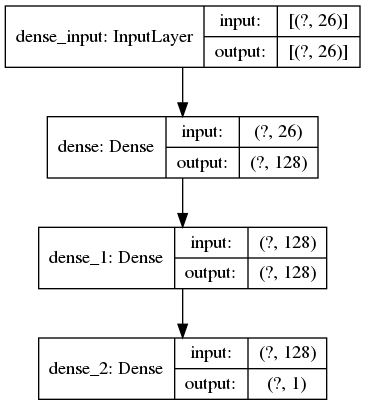

In [6]:
model = Sequential([
    Dense(128, activation='relu', input_shape=[len(X_test.keys())]),
    Dense(128, activation='relu'),
    Dense(1)
  ])


plot_model(model, show_shapes = True)



In [7]:
training_params = {
    'loss': "mse",
    'optimizer': tf.optimizers.RMSprop(lr=0.001),
    'metrics': ['mae', 'mse'],
#     'run_eagerly': False
}
model.compile(**training_params)




In [8]:
def train_evaluate_model(model, tag, X_train, y_train, X_test, y_test, callbacks = None, patience=50, epochs=200, metric="mse"):
    K.clear_session()

    folder = create_training_folder("",tag, add_timestamp=False)
    
    if callbacks is None:
        callbacks = []    
        callbacks.append(CSVLogger('{}/training_history.csv'.format(folder), append=True, separator=';'))
        stopper = keras.callbacks.EarlyStopping(monitor=metric,
            # "no longer improving" being defined as "no better than 1e-3 less"
            min_delta=0.0001,
            mode="min",
            # "no longer improving" being further defined as "for at least 8 epochs"
            patience=patience, verbose=1)
        callbacks.append(stopper)
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='{}/training_history.csv'.format("model.checkpoint"),
            save_weights_only=True,
            monitor=metric,
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)


    model.fit(X_train, y_train, epochs=epochs, verbose=2, validation_data=(X_test, y_test), callbacks = callbacks)

    loss = model.evaluate(X_test, y_test, verbose=0)

    print("Loss on test data: {}".format(loss))
    return folder
    

In [9]:

# scaler = preprocessing.StandardScaler().fit(X_train)
scaler = preprocessing.MinMaxScaler().fit(X_train)

folder = train_evaluate_model(model, "v2_ann_perc_detected", X_train, y_train, 
                                  scaler.transform(X_test), y_test, epochs=200)

model_folder = '{}/model'.format(folder)
model.save(model_folder)    

dump(scaler, os.path.join(folder, "scaler.joblib"))



Epoch 1/200
333/333 - 1s - loss: 4911.9546 - mae: 54.5212 - mse: 4911.9546 - val_loss: 0.0321 - val_mae: 0.0919 - val_mse: 0.0321
Epoch 2/200
333/333 - 1s - loss: 907.2360 - mae: 24.3270 - mse: 907.2360 - val_loss: 0.0299 - val_mae: 0.0810 - val_mse: 0.0299
Epoch 3/200
333/333 - 1s - loss: 253.4867 - mae: 11.6633 - mse: 253.4867 - val_loss: 0.0285 - val_mae: 0.0786 - val_mse: 0.0285
Epoch 4/200
333/333 - 1s - loss: 109.8107 - mae: 8.4169 - mse: 109.8107 - val_loss: 0.0261 - val_mae: 0.0718 - val_mse: 0.0261
Epoch 5/200
333/333 - 1s - loss: 39.5219 - mae: 5.1610 - mse: 39.5219 - val_loss: 0.0252 - val_mae: 0.0690 - val_mse: 0.0252
Epoch 6/200
333/333 - 1s - loss: 14.7798 - mae: 2.9974 - mse: 14.7798 - val_loss: 0.0245 - val_mae: 0.0680 - val_mse: 0.0245
Epoch 7/200
333/333 - 1s - loss: 5.4618 - mae: 1.8292 - mse: 5.4618 - val_loss: 0.0248 - val_mae: 0.0663 - val_mse: 0.0248
Epoch 8/200
333/333 - 1s - loss: 0.9459 - mae: 0.6000 - mse: 0.9459 - val_loss: 0.0257 - val_mae: 0.0665 - val_mse

Epoch 67/200
333/333 - 1s - loss: 0.0215 - mae: 0.0739 - mse: 0.0215 - val_loss: 0.0292 - val_mae: 0.1382 - val_mse: 0.0292
Epoch 68/200
333/333 - 1s - loss: 0.0216 - mae: 0.0737 - mse: 0.0216 - val_loss: 0.0299 - val_mae: 0.1418 - val_mse: 0.0299
Epoch 69/200
333/333 - 1s - loss: 0.0215 - mae: 0.0740 - mse: 0.0215 - val_loss: 0.0298 - val_mae: 0.1414 - val_mse: 0.0298
Epoch 70/200
333/333 - 1s - loss: 0.0215 - mae: 0.0729 - mse: 0.0215 - val_loss: 0.0312 - val_mae: 0.1478 - val_mse: 0.0312
Epoch 71/200
333/333 - 1s - loss: 0.0213 - mae: 0.0734 - mse: 0.0213 - val_loss: 0.0317 - val_mae: 0.1503 - val_mse: 0.0317
Epoch 72/200
333/333 - 1s - loss: 0.0213 - mae: 0.0733 - mse: 0.0213 - val_loss: 0.0329 - val_mae: 0.1552 - val_mse: 0.0329
Epoch 73/200
333/333 - 1s - loss: 0.0215 - mae: 0.0742 - mse: 0.0215 - val_loss: 0.0309 - val_mae: 0.1469 - val_mse: 0.0309
Epoch 74/200
333/333 - 1s - loss: 0.0213 - mae: 0.0727 - mse: 0.0213 - val_loss: 0.0339 - val_mae: 0.1594 - val_mse: 0.0339
Epoch 75

Epoch 133/200
333/333 - 1s - loss: 0.0191 - mae: 0.0688 - mse: 0.0191 - val_loss: 0.0721 - val_mae: 0.2584 - val_mse: 0.0721
Epoch 134/200
333/333 - 1s - loss: 0.0192 - mae: 0.0689 - mse: 0.0192 - val_loss: 0.0729 - val_mae: 0.2600 - val_mse: 0.0729
Epoch 135/200
333/333 - 1s - loss: 0.0188 - mae: 0.0682 - mse: 0.0188 - val_loss: 0.0710 - val_mae: 0.2563 - val_mse: 0.0710
Epoch 136/200
333/333 - 1s - loss: 0.0191 - mae: 0.0689 - mse: 0.0191 - val_loss: 0.0685 - val_mae: 0.2514 - val_mse: 0.0685
Epoch 137/200
333/333 - 1s - loss: 0.0190 - mae: 0.0686 - mse: 0.0190 - val_loss: 0.0711 - val_mae: 0.2566 - val_mse: 0.0711
Epoch 138/200
333/333 - 1s - loss: 0.0191 - mae: 0.0684 - mse: 0.0191 - val_loss: 0.0685 - val_mae: 0.2512 - val_mse: 0.0685
Epoch 139/200
333/333 - 1s - loss: 0.0191 - mae: 0.0691 - mse: 0.0191 - val_loss: 0.0711 - val_mae: 0.2564 - val_mse: 0.0711
Epoch 140/200
333/333 - 1s - loss: 0.0190 - mae: 0.0692 - mse: 0.0190 - val_loss: 0.0711 - val_mae: 0.2564 - val_mse: 0.0711


Epoch 199/200
333/333 - 1s - loss: 0.0180 - mae: 0.0672 - mse: 0.0180 - val_loss: 0.0950 - val_mae: 0.2991 - val_mse: 0.0950
Epoch 200/200
333/333 - 1s - loss: 0.0180 - mae: 0.0667 - mse: 0.0180 - val_loss: 0.0935 - val_mae: 0.2965 - val_mse: 0.0935
Loss on test data: [0.09350483119487762, 0.2964673340320587, 0.09350483119487762]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/roya/results//v2_ann_perc_detected/model/assets


['/home/gus/workspaces/wpy/roya/results//v2_ann_perc_detected/scaler.joblib']

Best f1-score on test dataset: **0.7120**

In [10]:
BASE_FOLDER = "../../results/"

def plot_results(training_folder, metric = None):
    if not metric:
        metric = "f1"
    path = os.path.join(BASE_FOLDER, training_folder, "training_history.csv")
    df = pd.read_csv(path, sep=";")

    print("Results file: {}".format(training_folder))
    print("Last 10 records avg: ")
    print(df.tail(10).mean())

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    plt.title(training_folder)
    df = df.loc[5:,:]
    axs[0].plot(df["loss"], label='loss')
    axs[0].plot(df["val_loss"], label='val_loss')
    axs[0].legend(loc="upper right")
    axs[1].plot(df[metric], label=metric)
    axs[1].plot(df["val_"+metric], label='val_'+metric)
    axs[1].legend(loc="lower right")
    

Results file: ann_v1
Last 10 records avg: 
epoch       5.500000
loss        0.023681
mae         0.080327
mse         0.023681
val_loss    0.024638
val_mae     0.081187
val_mse     0.024638
dtype: float64


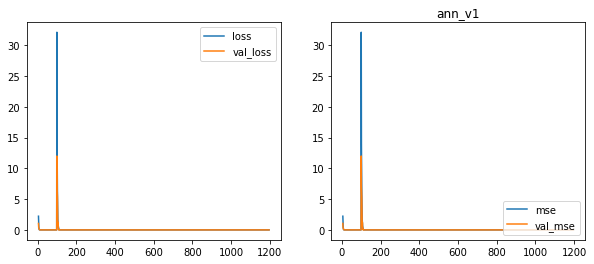

In [11]:
plot_results("ann_v1", metric="mse")

In [12]:
y_pred_val = model.predict(scaler.transform(X_val))


print("MSE sobre el conjunto de validación: {}".format(mean_squared_error(y_val, y_pred_val)))
print("MAE sobre el conjunto de validación: {}".format(mean_absolute_error(y_val, y_pred_val)))

MSE sobre el conjunto de validación: 0.08634406901770696
MAE sobre el conjunto de validación: 0.28545392063403224
